# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №2: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 24 марта 18:00 Сдача **очная** на занятии. <br\>


Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст, если явно не указана такая возможность. В противном случае -1 балл
<hr\>

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle as sh

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Здравствуйте, уважаемые студенты! 

В этом задании мы будем реализовать линейные модели. Необходимо реализовать линейную и логистическую регрессии с L2 регуляризацией

# Теоретическое введение



Линейная регрессия решает задачу регрессии и оптимизирует функцию потерь MSE 

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right], $$ где $y_i$ $-$ целевая функция,  $a_i = a(x_i) =  \langle\,x_i,w\rangle ,$ $-$ предсказание алгоритма на объекте $x_i$, $w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Не забываем, что здесь и далее  мы считаем, что в $x_i$ есть тождественный вектор единиц, ему соответствует вес $w_0$.


Логистическая регрессия является линейным классификатором, который оптимизирует так называемый функционал log loss:

$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right],$$
где  $y_i  \in \{0,1\}$ $-$ метка класса, $a_i$ $-$ предсказание алгоритма на объекте $x_i$. Модель пытается предсказать апостериорую вероятность объекта принадлежать к классу "1":
$$ p(y_i = 1 | x_i) = a(x_i) =  \sigma( \langle\,x_i,w\rangle ),$$
$w$ $-$ вектор весов (размерности $D$), $x_i$ $-$ вектор признаков (такой же размерности $D$).

Функция $\sigma(x)$ $-$ нелинейная функция, пероводящее скалярное произведение объекта на веса в число $\in (0,1)$ (мы же моделируем вероятность все-таки!)

$$\sigma(x) = \frac{1}{1 + \exp(-x)}$$

Если внимательно посмотреть на функцию потерь, то можно заметить, что в зависимости от правильного ответа алгоритм штрафуется или функцией $-\log a_i$, или функцией $-\log (1 - a_i)$.



Часто для решения проблем, которые так или иначе связаны с проблемой переобучения, в функционал качества добавляют слагаемое, которое называют ***регуляризацией***. Итоговый функционал для линейной регрессии тогда принимает вид:

$$L(w) =  \frac{1}{N}\left[\sum_i (y_i - a_i) ^ 2 \right] + \frac{1}{C}R(w) $$

Для логистической: 
$$L(w) = - \frac{1}{N}\left[\sum_i y_i \log a_i + ( 1 - y_i) \log (1 - a_i) \right] +  \frac{1}{C}R(w)$$

Самое понятие регуляризации введено основателем ВМК академиком Тихоновым https://ru.wikipedia.org/wiki/Метод_регуляризации_Тихонова

Идейно методика регуляризации заключается в следующем $-$ мы рассматриваем некорректно поставленную задачу (что это такое можно найти в интернете), для того чтобы сузить набор различных вариантов (лучшие из которых будут являться переобучением ) мы вводим дополнительные ограничения на множество искомых решений. На лекции Вы уже рассмотрели два варианта регуляризации.

$L1$ регуляризация:
$$R(w) = \sum_{j=1}^{D}|w_j|$$
$L2$ регуляризация:
$$R(w) =  \sum_{j=1}^{D}w_j^2$$

С их помощью мы ограничиваем модель в  возможности выбора каких угодно весов минимизирующих наш лосс, модель уже не сможет подстроиться под данные как ей угодно. 

Вам нужно добавить соотвествущую Вашему варианту $L2$ регуляризацию.

И так, мы поняли, какую функцию ошибки будем минимизировать, разобрались, как получить предсказания по объекту и обученным весам. Осталось разобраться, как получить оптимальные веса. Для этого нужно выбрать какой-то метод оптимизации.



Градиентный спуск является самым популярным алгоритмом обучения линейных моделей. В этом задании Вам предложат реализовать стохастический градиентный спуск или  мини-батч градиентный спуск (мини-батч на русский язык довольно сложно перевести, многие переводят это как "пакетный", но мне не кажется этот перевод удачным). Далее нам потребуется определение **эпохи**.
Эпохой в SGD и MB-GD называется один проход по **всем** объектам в обучающей выборки.
* В SGD градиент расчитывается по одному случайному объекту. Сам алгоритм выглядит примерно так:
        1) Перемешать выборку
        2) Посчитать градиент функции потерь на одном объекте (далее один объект тоже будем называть батчем)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* В Mini Batch SGD - по подвыборке объектов. Сам алгоритм выглядит примерно так::
        1) Перемешать выборку, выбрать размер мини-батча (от 1 до размера выборки)
        2) Почитать градиент функции потерь по мини-батчу (не забыть поделить на  число объектов в мини-батче)
        3) Сделать шаг спуска
        4) Повторять 2) и 3) пока не пройдет максимальное число эпох.
* Для отладки алгоритма реализуйте возможность  вывода средней ошибки на обучении модели по объектам (мини-батчам). После шага градиентного спуска посчитайте значение ошибки на объекте (или мини-батче), а затем усредните, например, по ста шагам. Если обучение проходит корректно, то мы должны увидеть, что каждые 100 шагов функция потерь уменьшается. 
* Правило останова - максимальное количество эпох
    


# Теоретические вопросы (2 балла)
В этой части Вам будут предложены теоретичские вопросы и задачи по теме. Вы, конечно, можете списать их у своего товарища или найти решение в интернете, но учтите, что они обязательно войдут в теоретический коллоквиум. Лучше разобраться в теме сейчас и успешно ответить на коллоквиуме, чем списать, не разобравшись в материале, и быть терзаемым совестью. 


Формулы надо оформлять в формате **LaTeX**.

Задача 1. Градиент для линейной регрессии.
* Выпишите формулу обновления весов для линейной регрессии с L2 регуляризацией для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент?

***Ваше решение здесь***
$$ w_{new} = w_{old} - \alpha\left(\frac{1}{N}\sum\limits_{i=1}^{N}(x_i(x_i*w_{old} - y_i)) + \frac{1}{C}w_{old}\right)$$

Задача 2. Градиент для логистической регрессии.
* Выпишите формулу обновления весов для логистической регрессии с L2 регуляризацией  для мини-батч градиентого спуска размера $n$:

$$ w_{new} = w_{old} - ... $$

 Отнеситесь к этому пункту максимально серьезно, это Вам нужно будет реализовать в задании.
 
Проанализруйте итоговую формулу градиента - как  интуитивно можно  описать, чему равен градиент? Как соотносится этот градиент с градиентом, возникающий в задаче линейной регрессии?

Подсказка: Вам градиент, которой получается если “в лоб” продифференцировать,  надо немного преобразовать.
Надо подставить, что $1 - \sigma(w,x) $ это  $1 - a(x_i)$, а  $-\sigma(w,x)$ это $0 - a(x_i)$.  Тогда получится свести к одной красивой формуле с линейной регрессией, которую программировать будет намного проще.

***Ваше решение здесь***
$$ w_{new} = w_{old} - \alpha\left(\sum\limits_{i=1}^{N}[1 - \sigma(<w,x_i>*y_i)]x_iy_i + \frac{1}{C}w_{old}\right)$$  для таргета Y = {-1, 1}

Задача 3. Точное решение линейной регрессии

На лекции было показано, что точное решение линейной регрессии имеет вид $w = (X^TX)^{-1}X^TY $. 
* Покажите, что это действительно является точкой минимума в случае, если матрица X имеет строк не меньше, чем столбцов и имеет полный ранг. Подсказка: посчитайте Гессиан и покажите, что в этом случае он положительно определен. 
* Выпишите точное решение для модели с $L2$ регуляризацией. Как L2 регуляризация помогает с точным решением где матрица X имеет линейно зависимые признаки?

***Ваше решение здесь***

Для градиента эмпирического риска справдлива формула $\nabla Q_w = 2X^TX*w - 2X^TY$.
Взяв вторую производную функции эмпирического риска по $w$ получем матрицу Гессе имеющюю вид $G = 2X^TX$.

По однуму из критериев положительной определенности матрицы: матрица $G$ положительно определена тогда и только тогда, когда существует матрица $X$ такая, что верно разложение $G = X^TX$.
Следовательно Гессиан $G(w)$ положительно определен $=>$ при $w = (X^TX)^{-1}X^TY $ достигается минимум эмпирического риска


Задача 4.  Предсказываем вероятности.

Когда говорят о логистической регрессии, произносят фразу, что она "предсказывает вероятности положительного класса". Давайте разберемся, что же за этим стоит. Посчитаем математическое ожидание функции потерь и проверим, что предсказание алгоритма, оптимизирующее это мат. ожидание, будет являться вероятностью положительного класса. 

И так, функция потерь на объекте $x_i$, который имеет метку $y_i \in \{0,1\}$  для предсказания $a(x_i)$ равна:
$$L(y_i, b) =-[y_i == 1] \log a(x_i)  - [y_i == 0] \log(1 - a(x_i)) $$

Где $[]$ означает индикатор $-$ он равен единице, если значение внутри него истинно, иначе он равен нулю. Тогда мат. ожидание при условии конкретного $x_i$  по определение мат. ожидания дискретной случайной величины:
$$E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i))$$
* Докажите, что значение $a(x_i)$, минимизирующее данное мат. ожидание, в точности равно $p(y_i = 1 |x_i)$, то есть равно вероятности положительного класса.

Подсказка: возможно, придется воспользоваться, что  $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$

***Ваше решение здесь***


1. $p(y_i = 1 | x_i) + p(y_i = 0 | x_i) = 1$ тогда $p(y_i = 0 | x_i) = 1 - p(y_i = 1 | x_i)$
2. Обозначим $p(y_i = 1 | x_i)$ как $p_1$ и $p(y_i = 0 | x_i)$ как $p_0$
3. $E(L | x_i) = -p(y_i = 1 |x_i ) \log a(x_i)  - p(y_i = 0 | x_i) \log( 1 - a(x_i)) =$

$= p_1*\log(1 - a(x_i)) - \log( 1 - a(x_i)) - p_i*\log(a(x_i)) =$

$= p_1*\log\frac{(1 - a(x_i))}{a(x_i)} - \log( 1 - a(x_i))$
4. Для поиска $a(x_i)$ минимизирующого мат. ожидание, возьмем производную по $a$ и приравняем к нулю, получим 
$ -p_1\frac{a(x_i)}{(1 - a(x_i))}\frac{1}{a(x_i)^2} + \frac{1}{1 - a(x_i)} = 0$
5. Сокращая получим что $p1 = a(x_i)$, что и требовалось доказать

Задача 5.  Смысл регуляризации.

Нужно ли в L1/L2 регуляризации использовать свободный член $w_0$ (который не умножается ни на какой признак)?

Подсказка: подумайте, для чего мы вводим $w_0$

***Ваше решение здесь***
$w_0$ не должен учавствовать в регуляризации так как он определяется значения целевой переменной при нулевых значениях признаков т.е. показывает начальный сдвиг относительно начала координат.

Соответственно фиксирован и не должен учавствовать в минимизации весов. Нам не нужно штрафовать модель за его большое значение, значит признак $w_0$ НЕ ДОЛЖЕН учавтсвовать в регуляризации

#  Реализация линейной модели (4 балла)

## Зачем нужны батчи?


Как Вы могли заметить из теоретического введения, что в случае SGD, что в случа mini-batch GD,  на каждой итерации обновление весов  происходит только по небольшой части данных (1 пример в случае SGD, batch примеров в случае mini-batch). То есть для каждой итерации нам *** не нужна вся выборка***. Мы можем просто итерироваться по выборке, беря батч нужного размера (далее 1 объект тоже будем называть батчом).

Легко заметить, что в этом случае нам не нужно загружать все данные в оперативную память, достаточно просто считать батч с диска, обновить веса, считать диска другой батч и так далее. В целях упрощения домашней работы, прямо с диска  мы считывать не будем, будем работать с обычными numpy array. 





## Немножко про генераторы в Python



Идея считывания данных кусками удачно ложится на так называемые ***генераторы*** из языка Python. В данной работе Вам предлагается не только разобраться с логистической регрессией, но  и познакомиться с таким важным элементом языка.  При желании Вы можете убрать весь код, связанный с генераторами, и реализовать логистическую регрессию и без них, ***штрафоваться это никак не будет***. Главное, чтобы сама модель была реализована правильно, и все пункты были выполнены. 

Подробнее можно почитать вот тут https://anandology.com/python-practice-book/iterators.html


К генератору стоит относиться просто как к функции, которая порождает не один объект, а целую последовательность объектов. Новое значение из последовательности генерируется с помощью ключевого слова ***yield***. Ниже Вы можете насладиться  генератором чисел Фибоначчи.

In [29]:
def fib(max_iter=4):
    a, b = 0, 1
    iter_num = 0
    while 1:
        yield a
        a, b = b, a + b
        iter_num += 1
        if iter_num == max_iter:
            break

Вот так можно сгенерировать последовательность Фибоначчи. 

Заметьте, что к генераторам можно применять некоторые стандартные функции из Python, например enumerate.

In [30]:
new_generator = fib()
for j, fib_val in enumerate(new_generator):
    print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Пересоздавая объект, можно сколько угодно раз генерировать заново последовательность. 

In [31]:
for i in range(0, 3):
    new_generator = fib()
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2
Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


А вот так уже нельзя.

In [32]:
new_generator = fib()
for i in range(0, 3):
    for j, fib_val in enumerate(new_generator):
        print ("Fib num: " + str(j) + " fib values: " + str(fib_val))

Fib num: 0 fib values: 0
Fib num: 1 fib values: 1
Fib num: 2 fib values: 1
Fib num: 3 fib values: 2


Концепция крайне удобная для обучения  моделей $-$ у Вас есть некий источник данных, который Вам выдает их кусками, и Вам совершенно все равно откуда он их берет. Под ним может скрывать как массив в оперативной памяти, как файл на жестком диске, так и SQL база данных. Вы сами данные никуда не сохраняете, оперативную память экономите.

Если Вам понравилась идея с генераторами, то Вы можете реализовать свой, используя прототип batch_generator. В нем Вам нужно выдавать батчи признаков и ответов для каждой новой итерации спуска. Если не понравилась идея, то можете реализовывать SGD или mini-batch GD без генераторов.

In [35]:
def batch_generator(X, y, shuffle=True, batch_size=5):
    """
    Гератор новых батчей для обучения
    X          - матрица объекты-признаки
    y_batch    - вектор ответов
    shuffle    - нужно ли случайно перемешивать выборку
    batch_size - размер батча ( 1 это SGD, > 1 mini-batch GD)
    Генерирует подвыборку для итерации спуска (X_batch, y_batch)
    """
        
    if shuffle:
        X, y = sh(X, y)
    for i in range(0, X.shape[0], batch_size):
        X_batch = X[i:i+batch_size]
        y_batch = y[i:i+batch_size]
        yield (X_batch, y_batch)

# Теперь можно сделать генератор по данным ()
#  my_batch_generator = batch_generator(X, y, shuffle=True, batch_size=1):

In [36]:
X = np.arange(20).reshape(-1,2)
# print(X)
y = [0, 1, 1, 1, 0, 1, 0, 0, 1, 0]
for i,j in batch_generator(X, y):
    print(i,j)

print(X * np.asarray(y).reshape(-1,1))
a = np.asarray([1, 2, 3])
b = np.asarray([4, 5, 6])
print(a*b)
print(y)


[[10 11]
 [12 13]
 [ 0  1]
 [18 19]
 [ 2  3]] [1, 0, 0, 0, 1]
[[14 15]
 [ 4  5]
 [ 6  7]
 [16 17]
 [ 8  9]] [0, 1, 1, 1, 0]
[[ 0  0]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 0  0]
 [10 11]
 [ 0  0]
 [ 0  0]
 [16 17]
 [ 0  0]]
[ 4 10 18]
[0, 1, 1, 1, 0, 1, 0, 0, 1, 0]


In [37]:
x = [1, 2, 3]
y = [2, 3, 4]
z = np.einsum('i,i->i', x, y)
# print(z)
a = np.arange(25).reshape(5,5)
b = np.arange(5)
print(a)
print(b)
z = np.einsum('ij,i->i', a, b)
print(z)

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
[0 1 2 3 4]
[  0  35 120 255 440]


In [151]:
#%%pycodestyle

def sigmoid(x):
    """
    Вычисляем значение сигмоида.
    X - выход линейной модели
    """
    sigm_value_x = 1/(1 + np.exp(-x))
    return sigm_value_x


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, 
                 batch_generator, 
                 C=1, 
                 alpha=0.01, 
                 max_epoch=10, 
                 model_type='lin_reg', 
                 batch_size=10,
                 limit = 1):
        """
        batch_generator -- функция генератор, которой будем создавать батчи
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        model_type - тим модели, lin_reg или log_reg
        """      
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.batch_generator = batch_generator
        self.errors_log = {'iter' : [], 'loss' : []}  
        self.model_type = model_type
        self.batch_size = batch_size
        self.limit = limit
        
    def calc_loss(self, X_batch, y_batch):
        """
        Считаем функцию потерь по батчу 
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """        
        L2 = (1/(2*self.C))*np.dot(self.weights.T, self.weights)
        
        if self.model_type == 'lin_reg':
            loss = np.dot(X_batch, self.weights) - y_batch
            loss = np.dot(loss.T, loss)/2
            
        elif self.model_type == 'log_reg':
            margin = np.dot(X_batch, self.weights)*y_batch
            loss = -np.log(sigmoid(margin)).sum() 
                
            loss += L2       
        return loss
    
    def calc_loss_grad(self, X_batch, y_batch):
        """
        Считаем  градиент функции потерь по батчу (то что Вы вывели в задании 1)
        X_batch - матрица объекты-признаки по батчу
        y_batch - вектор ответов по батчу
        Не забудте тип модели (линейная или логистическая регрессия)!
        """
        L2_incl = (1/self.C) * self.weights
        L2_incl[0] = 0
        
        if self.model_type == 'lin_reg':
            loss_grad = np.dot(X_batch.T, (np.dot(X_batch, self.weights) - y_batch))/X_batch.shape[0]

        elif self.model_type == 'log_reg':
            margin = np.dot(X_batch, self.weights)*y_batch
            loss_grad = np.einsum('ij,i->j', X_batch, np.einsum('i,i->i', (1 - sigmoid(-margin)), y_batch))
            
        loss_grad += L2_incl
        return loss_grad
    
    def update_weights(self, new_grad):
        """
        Обновляем вектор весов
        new_grad - градиент по батчу
        """
#         print("weights = {}", self.weights)
        self.weights -= self.alpha*new_grad
        pass
    
    def fit(self, X, y):
        '''
        Обучение модели
        X - матрица объекты-признаки
        y - вектор ответов
        '''
        X = np.column_stack((np.ones(X.shape[0]), X))        
        np.random.seed(0)
        self.weights = np.random.random(X.shape[1])*10 - 5 
        for n in range(0, self.max_epoch):
            new_epoch_generator = self.batch_generator(X, y, batch_size=self.batch_size)
            for batch_num, new_batch in enumerate(new_epoch_generator):
                X_batch = new_batch[0]
                y_batch = new_batch[1]
#                 print(X_batch, y_batch)
                batch_grad = self.calc_loss_grad(X_batch, y_batch)
                batch_loss = self.calc_loss(X_batch, y_batch)
                self.update_weights(batch_grad)  
                self.errors_log['iter'].append(batch_num)
                self.errors_log['loss'].append(batch_loss)
                
        return self
        
    def predict(self, X):
        '''
        Предсказание класса
        X - матрица объекты-признаки
        Не забудте тип модели (линейная или логистическая регрессия)!
        '''      
        X = np.column_stack((np.ones(X.shape[0]), X))
        y_hat = np.dot(X, self.weights)
        pred = np.sign(y_hat)
        if self.model_type == 'log_reg':
            y_hat = sigmoid(y_hat)
#             y_hat = np.where(pred > 0, 1, 0)
        print(y_hat)
        # Желательно здесь использовать матричные операции между X и весами, например, numpy.dot 
        return (y_hat > self.limit) * 1

Запустите обе регрессии на синтетических данных. 


Выведите полученные веса и нарисуйте разделяющую границу между классами (используйте только первых два веса для первых двух признаков X[:,0], X[:,1] для отображения в 2d пространство ).  

In [94]:
def plot_decision_boundary(clf):
    ## Your code Here
    w = clf.weights
    x = np.linspace(-3, 2)
    y =  -(w[0]+x*w[1])/w[2]
    print(w)
    plt.plot(x, y, label = clf.model_type)
    plt.legend()

In [95]:
def print_log(clf, step = 10):
    for i in range(0, len(clf.errors_log['iter']), step):
        for k, v in clf.errors_log.items():
            print(k, v[i])
            print()

[-0.00047597  0.34245614 -0.14504422]
[ 0.08472288 -1.15302051  0.54305746]
-------------------------------------------------------


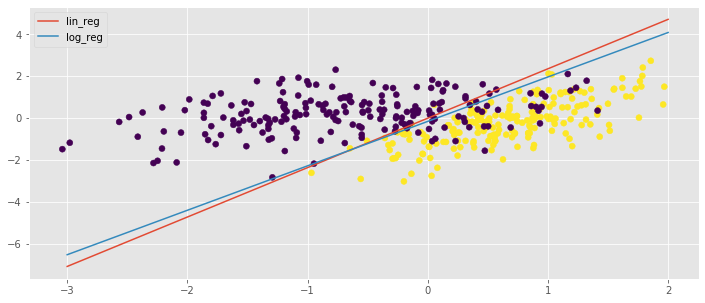

In [96]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

y = np.where(y > 0, y, -1)
X = (X - X.mean(axis=0))/X.std(axis=0)

lin_reg = MySGDClassifier(batch_generator, C=1, max_epoch=100, model_type='lin_reg', batch_size=10)
lin_reg.fit(X, y)
plot_decision_boundary(lin_reg)
# print_log(lin_reg)
log_reg = MySGDClassifier(batch_generator, C=1, max_epoch=20, model_type='log_reg', batch_size=10)
log_reg.fit(X, y)
plot_decision_boundary(log_reg)
print('-------------------------------------------------------')
# print_log(log_reg)
plt.scatter(X[:,0], X[:,1], c=y)

Далее будем анализировать Ваш алгоритм. 
Для этих заданий используйте датасет ниже.

In [42]:
from sklearn.datasets import make_classification

In [43]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимости обеих регрессией на этом датасете: изобразите график  функции потерь, усредненной по $N$ шагам градиентого спуска, для разных `alpha` (размеров шага). Разные `alpha` расположите на одном графике. 

$N$ можно брать 10, 50, 100 и т.д. 

In [44]:
## Your Code Here
def plot_loss(model='lin_reg', N=10, alpha=0.01):
    """
    Отрисовка графика функции потерь 
    для заданного альфа, шага усреднения и заданной модели
    """   
    log_reg = MySGDClassifier(batch_generator,
                              C=1,
                              alpha=alpha,
                              max_epoch=20,
                              model_type=model,
                              batch_size=1000)
    log_reg.fit(X, y)
    mean_loss = []
    x = list(range(len(log_reg.errors_log['loss']) // N))
    for i in range(0, len(log_reg.errors_log['loss']), N):
        mean_loss.append(np.mean(log_reg.errors_log['loss'][i : i + N]))
    x = np.linspace(0, 2, len(mean_loss))
    plt.plot(x , mean_loss, label="alpha = {}".format(alpha) )
    plt.legend()

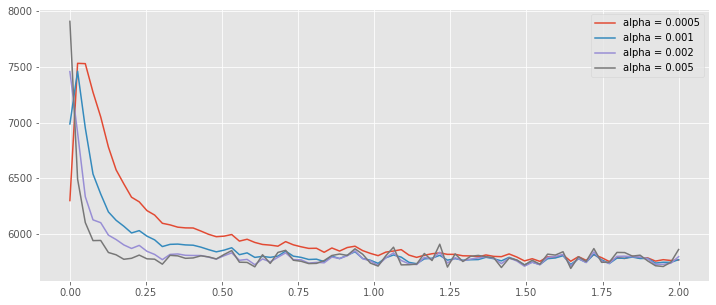

In [45]:
y = np.where(y > 0, y, -1)
alphas = (0.0005, 0.001, 0.002, 0.005)
for a in alphas:
    plot_loss(model='log_reg', alpha=a, N=25)

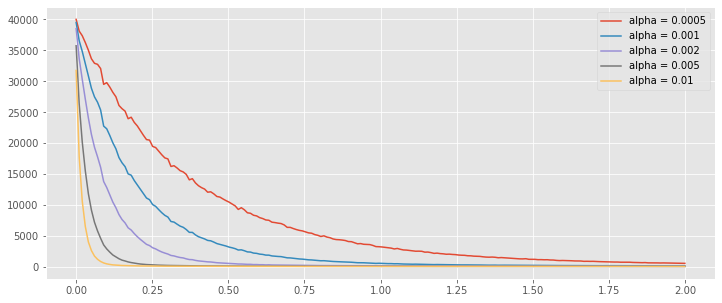

In [46]:
alphas = (0.0005, 0.001, 0.002, 0.005, 0.01)
for a in alphas:
    plot_loss(model='lin_reg', alpha=a, N=10)

Что Вы можете сказать про сходимость метода при различных `alpha`? Какое значение стоит выбирать для лучшей сходимости?

-- При увеличении `alpha` увеличивается скорость сходимости, что не удивительно ведь `alpha` отвечает за скорость
сходимости по определению

Изобразите график среднего значения весов для обеих регрессий в зависимости от коеф. регуляризации С из `np.logspace(3, -3, 10)` 

In [47]:
## Your Code Here
def plot_mean_weights(model='lin_reg'):
    """
    Орисовка графика средних весов для заданной модели
    """
    mean_weights = []
    for const in np.logspace(3, -3, 10):
        lin_reg = MySGDClassifier(batch_generator, 
                                  C=const,
                                  alpha=0.0001,
                                  max_epoch=20,
                                  model_type=model,
                                  batch_size=100)
        lin_reg.fit(X, y)
        mean_weights.append(np.mean(lin_reg.weights[1:]))
    x = np.linspace(0, 10, len(mean_weights))
    plt.plot(x, mean_weights, label=model)
    plt.legend()

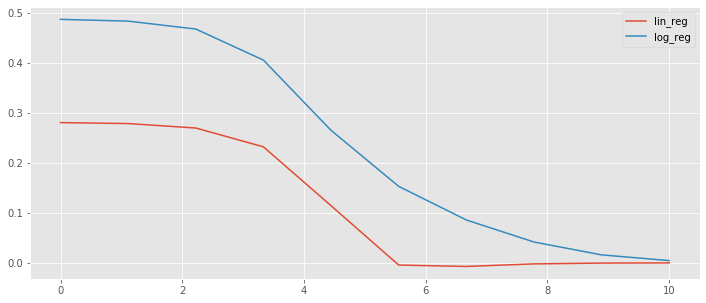

In [48]:
plot_mean_weights(model='lin_reg')
plot_mean_weights(model='log_reg')

Довольны ли Вы, насколько сильно уменьшились Ваши веса? 



# Боевое применение (4  балла)

**Защита данной части возможна только при преодолении в проекте бейзлайна Handmade baseline.**

Давайте применим модель на итоговом проекте! Датасет сделаем точно таким же образом, как было показано в project_overview.ipynb

Применим обе регрессии, подберем для них параметры и сравним качество. Может быть Вы еще одновременно с решением домашней работы подрастете на лидерборде!

In [152]:
doc_to_title = {}
with open('docs_titles.tsv') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
#         print(line)
        data = line.strip().split('\t', 1)
#         print('data = ',data)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
# print(doc_to_title)
print (len(doc_to_title))   

28026


In [153]:
import pandas as pd
train_data = pd.read_csv('train_groups.csv')
traingroups_titledata = {}
for i in range(len(train_data)):
    new_doc = train_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    target = new_doc['target']
    title = doc_to_title[doc_id]
    if doc_group not in traingroups_titledata:
        traingroups_titledata[doc_group] = []
    traingroups_titledata[doc_group].append((doc_id, title, target))

In [154]:
import numpy as np
y_train = []
X_train = []
groups_train = []
for new_group in traingroups_titledata:
    docs = traingroups_titledata[new_group]
    for k, (doc_id, title, target_id) in enumerate(docs):
        y_train.append(target_id)
        groups_train.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j, target_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_train.append(sorted(all_dist, reverse=True)[0:15]    )
X_train = np.array(X_train)
y_train = np.array(y_train)
groups_train = np.array(groups_train)
print (X_train, y_train, groups_train)

[[4 4 3 ... 2 1 1]
 [8 7 7 ... 2 2 2]
 [2 2 2 ... 1 1 1]
 ...
 [0 0 0 ... 0 0 0]
 [6 2 1 ... 1 1 1]
 [3 2 2 ... 1 1 1]] [0 0 0 ... 0 0 0] [  1   1   1 ... 129 129 129]


Подберите размер батча для обучения. Линейная модель не должна учиться дольше нескольких минут. 

Не забывайте использовать скейлер!

In [155]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [156]:
def group_sep(groups_train):
    for i in range(1, groups_train[-1]):
        j = 0
        while groups_train[j] == i:
            j += 1
        

In [157]:
lin_reg = MySGDClassifier(batch_generator, 
                          C=1,
                          alpha=0.0001,
                          max_epoch=20,
                          model_type='lin_reg',
                          batch_size=1000)

Разбейте данные на обучение и валидацию. Подберите параметры C, alpha, max_epoch, model_type на валидации (Вы же помните, как правильно в этой задаче делать валидацию?)

Подберите порог линейной модели, по достижении которого, Вы будете относить объект к классу 1. Вспомните, какую метрику мы оптимизируем в соревновании.  Как тогда правильно подобрать порог?

In [158]:
test_data = pd.read_csv('test_groups.csv')
testgroups_titledata = {}

for i in range(len(test_data)):
    new_doc = test_data.iloc[i]
    doc_group = new_doc['group_id']
    doc_id = new_doc['doc_id']
    title = doc_to_title[doc_id]
    if doc_group not in testgroups_titledata:
        testgroups_titledata[doc_group] = []
    testgroups_titledata[doc_group].append((doc_id, title))

In [159]:
X_test = []
groups_test = []

for new_group in testgroups_titledata:
    docs = testgroups_titledata[new_group]
    for k, (doc_id, title) in enumerate(docs):
        groups_test.append(new_group)
        all_dist = []
        words = set(title.strip().split())
        for j in range(0, len(docs)):
            if k == j:
                continue
            doc_id_j, title_j = docs[j]
            words_j = set(title_j.strip().split())
            all_dist.append(len(words.intersection(words_j)))
        X_test.append(sorted(all_dist, reverse=True)[0:15])
X_test = np.array(X_test)
groups_test = np.array(groups_test)

In [160]:
scaler = StandardScaler()
log_reg = MySGDClassifier(batch_generator, 
                          C=1,
                          alpha=0.001,
                          max_epoch=20,
                          model_type='log_reg',
                          batch_size=1000,
                          limit = 0.7) 
print(y_train[:20])
y_train = np.where(y_train > 0, 1, -1)
print(y_train)
scaler.fit(X_train)
log_reg.fit(scaler.transform(X_train), y_train)
y_pred = log_reg.predict(scaler.transform(X_test))
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[-1 -1 -1 ... -1 -1 -1]
[0.66711496 0.67255392 0.19120447 ... 0.36953773 0.52303653 0.12009496]
[0 0 0 ... 0 0 0]


In [161]:
data = test_data
data['target'] = y_pred
data = data.drop(['group_id', 'doc_id'], axis=1)
data.to_csv("submission.csv", index=False)
# print(data.head(100))
data

pair_id  target
0        11691       0
1        11692       0
2        11693       0
3        11694       0
4        11695       0
...        ...     ...
16622    28313       1
16623    28314       1
16624    28315       0
16625    28316       0
16626    28317       0

[16627 rows x 2 columns]

С лучшими параметрами на валидации сделайте предсказание на тестовом множестве, отправьте его на проверку на платформу kaggle. Убедитесь, что Вы смогли побить public score первого бейзлайна.

** При сдаче домашки Вам необходимо кроме ссылки на ноутбук показать Ваш ник на kaggle, под которым Вы залили решение, которое побило Handmade baseline. **

# Фидбек (бесценно)

* Какие аспекты обучения линейных моделей Вам показались непонятными? Какое место стоит дополнительно объяснить?

***Ваше ответ здесь***

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.   

*** ВАШ ОТЗЫВ ЗДЕСЬ***